In [50]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

from matplotlib import pyplot as plt

def extract_timestep_per_second(folder_name):
    f = open(folder_name+"log.lammps", "r")
    for x in f:
        if x[:12] == "Performance:":
            Performance = x
    timestep_per_second = Performance.split()[5]
    return timestep_per_second

possible_combinations = np.loadtxt("lammps_input/possible_combination.dat")

performance_results = np.zeros((32,32))*np.nan
for nt, nx, ny in np.int32(possible_combinations):
    folder_name = 'nt'+str(nt)+'nx'+str(nx)+'ny'+str(ny)+'/'
    timestep_per_second = extract_timestep_per_second(folder_name)
    performance_results[nx-1][ny-1] = timestep_per_second
    if nx != ny:
        performance_results[ny-1][nx-1] = timestep_per_second

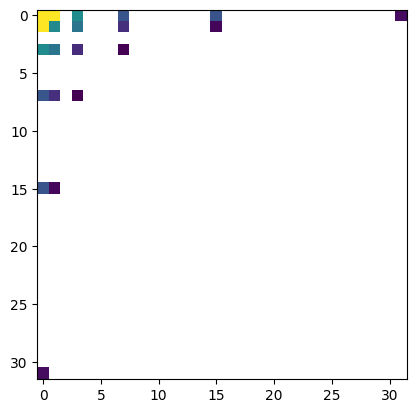

In [52]:
plt.imshow(performance_results)
plt.show()

[[12.233  0.     0.    ...  0.     0.     0.   ]
 [ 0.       nan  0.    ...  0.     0.     0.   ]
 [ 0.     0.       nan ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...    nan  0.     0.   ]
 [ 0.     0.     0.    ...  0.       nan  0.   ]
 [ 0.     0.     0.    ...  0.     0.       nan]]


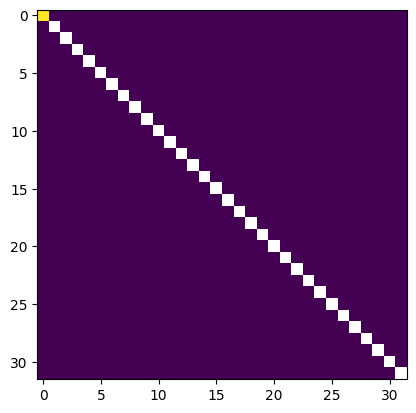

In [53]:
x, y = np.arange(32)+1, np.arange(32)+1
interp = RegularGridInterpolator((x, y), performance_results,
                                 method='linear', bounds_error=False,
                                 fill_value=None)

performance_interp = np.zeros((32,32))

for nx, ny in zip(np.arange(32)+1, np.arange(32)+1):
    nt = nx+ny
    performance_interp[nx-1][ny-1] = interp((nx, ny))

print(performance_interp)

plt.imshow(performance_interp)
plt.show()